In [31]:
continuous_series_names = [
    # 'quadr_small_ref',
    # 'brownian_motion', 
    # 'geometric_brownian_motion',
    # 'noisy_logistic_map',
    # 'logistic_map',
    # 'lorenz_system',
    # 'uncorrelated_gaussian',
    # 'uncorrelated_uniform'
    'gym_halfcheetah_full'
]
markov_chain_names = ['markov_chain']

import numpy as np

### Set up directory
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

from tqdm import tqdm
import pickle
import torch
from llama import get_model_and_tokenizer
from ICL import MultiResolutionPDF, recursive_refiner, trim_kv_cache, recursive_refiner_preprompt

# Check if directory exists, if not create it
save_path = Path(parent_dir) / 'processed_series_llama3'
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
# Define the directory where the generated series are stored
generated_series_dir = Path(parent_dir) / 'generated_series_RL'

In [32]:
def calculate_Markov(full_series, llama_size = '13b'):
    '''
     This function calculates the multi-resolution probability density function (PDF) for a given series.

     Parameters:
     full_series (str): The series for which the PDF is to be calculated.
     llama_size (str, optional): The size of the llama model. Defaults to '13b'.

     Returns:

    '''
    model, tokenizer = get_model_and_tokenizer(llama_size)
    states = sorted(set(full_series))
    good_tokens = [tokenizer.convert_tokens_to_ids(state) for state in states]
    batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True,        
    )
    torch.cuda.empty_cache()
    with torch.no_grad():
        out = model(batch['input_ids'].cpu())
    logit_mat = out['logits']
    logit_mat_good = logit_mat[:,:,good_tokens].cpu()

    return logit_mat_good

def calculate_multiPDF_llama3(
    full_series, temperature=1.0, number_of_tokens_original=None
):
    '''
     This function calculates the multi-resolution probability density function (PDF) for a given series.

     Parameters:
     full_series (str): The series for which the PDF is to be calculated.
     prec (int): The precision of the PDF.
     mode (str, optional): The mode of calculation. Defaults to 'neighbor'.
     refine_depth (int, optional): The depth of refinement for the PDF. Defaults to 1.
     llama_size (str, optional): The size of the llama model. Defaults to '13b'.
        
     Returns:
     list: A list of PDFs for the series.
    '''
    good_tokens_str = []
    for num in range(1000):
        good_tokens_str.append(str(num))
    good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]

    batch = tokenizer(
        [full_series],
        return_tensors="pt",
        add_special_tokens=True        
    )

    torch.cuda.empty_cache()
    with torch.no_grad():
        out = model(batch['input_ids'].cuda())  # use_cache=True)
    
    logit_mat = out['logits']
    
    # kv_cache_main = out['past_key_values']
    logit_mat_good = logit_mat[:,:,good_tokens].clone()
    
    if number_of_tokens_original:
        probs = torch.nn.functional.softmax(logit_mat_good[:,-(number_of_tokens_original-1):,:] / temperature, dim=-1)
    else:
        probs = torch.nn.functional.softmax(logit_mat_good[:,1:,:] / temperature, dim=-1)
    
    
    PDF_list = []
    
    # start_loop_from = 1 if use_instruct else 0
    for i in tqdm(range(1,int(probs.shape[1]),2)):
        PDF = MultiResolutionPDF()
        PDF.bin_center_arr = np.arange(0,1000) / 100
        PDF.bin_width_arr = np.array(1000*[0.01])
        PDF.bin_height_arr = probs[0,i,:].cpu().numpy() * 100

        PDF_list.append(PDF)
    
    # release memory
    del logit_mat  #, kv_cache_main
    return PDF_list

In [3]:
model, tokenizer = get_model_and_tokenizer('7b')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [33]:
# Initialize dictionaries to store the data for continuous series and Markov chains
continuous_series_task = {}
markov_chain_task = {}

# Loop through each file in the directory
for file in generated_series_dir.iterdir():
    # Check if a series is already processed
    # if not (save_path / file.name).exists():\
    # Extract the series name from the file name
    series_name = file.stem.rsplit('_', 1)[0]
    # If the series is a continuous series, load the data into the continuous_series_data dictionary
    if series_name in continuous_series_names:
        continuous_series_task[file.name] = pickle.load(file.open('rb'))
    # If the series is a Markov chain, load the data into the markov_chain_data dictionary
    elif series_name in markov_chain_names:
        markov_chain_task[file.name] = pickle.load(file.open('rb'))
    # If the series name is not recognized, raise an exception
    # else:
    #     raise Exception(f"Unrecognized series name: {series_name}")

In [34]:
print(continuous_series_task.keys())
print(markov_chain_task.keys())

dict_keys(['gym_halfcheetah_full_0.pkl'])
dict_keys([])


### Analyze Multi Digit series

In [35]:
T = 1.0
T_list = [0.5, 0.8, 1.0, 1.5, 2.0, 2.5]
# T_list = [1.0]
number_of_tokens_original = None
pre_prompt = ""
for series_name, series_dict in sorted(continuous_series_task.items()):
    print("Processing ", series_name)
    # if 'lorenz_system' in series_name:
    full_series = series_dict['full_series']
    print(f"full_series: {full_series[:10]}")
    prec = series_dict['prec']
    refine_depth = series_dict['refine_depth']
    llama_size = series_dict['llama_size']
    mode = series_dict['mode']
    number_of_tokens_original = len(tokenizer(full_series)['input_ids']) 
    print(f"number_of_tokens_original: {number_of_tokens_original}")
    print(f"comma token: {tokenizer(',')['input_ids']}")
    for T in T_list:
        PDF_list = calculate_multiPDF_llama3(
            pre_prompt+full_series,
            temperature=T,
            number_of_tokens_original=number_of_tokens_original
        )
        series_dict['PDF_list'] = PDF_list
        save_name = os.path.join(save_path, f"{series_name.split('.')[0]}_llama3_temp_{T}_preprompt.pkl")
        # save_name = os.path.join(save_path, series_name)
        with open(save_name, 'wb') as f:
            pickle.dump(series_dict, f)

Processing  gym_halfcheetah_full_0.pkl
full_series: 514,513,51
number_of_tokens_original: 7501
comma token: [128000, 11]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 3750/3750 [00:00<00:00, 7291.79it/s]


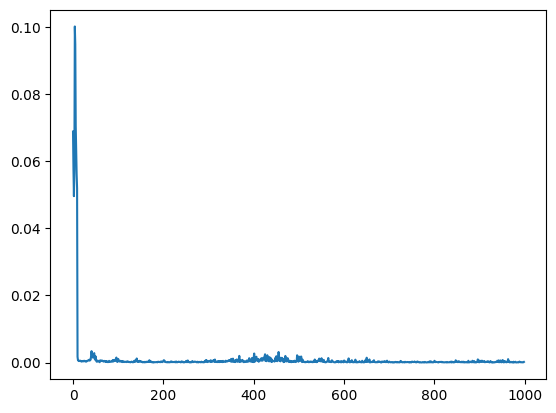

In [22]:
import matplotlib.pyplot as plt
x_lim = 999
plt.plot(np.arange(x_lim), probs[0,90,:x_lim].cpu().numpy())

### Analyze Markov Series

In [22]:
for series_name, series_dict in sorted(markov_chain_task.items()):
    print("Processing ", series_name)
    full_series = series_dict['full_series']
    llama_size = series_dict['llama_size']
    logit_mat_good = calculate_Markov(full_series, llama_size = llama_size)    
    series_dict['logit_mat_good'] = logit_mat_good
    save_name = os.path.join(save_path, series_name)
    with open(save_name, 'wb') as f:
        pickle.dump(series_dict, f)
    break

Processing  markov_chain_0.pkl


Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.89s/it]
